# IMEX-RB: A Fast and Stable Time Integration Method


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../utils'))

In [2]:
import numpy as np
from imexrb import imexrb
from euler import backward_euler, forward_euler
import mpl_pubstyle
from errors import compute_errors

## Solving a 1D Heat Equation

We want to solve the 1D heat equation on the interval $x \in [0, L]$, $t > 0$:

$$
\frac{\partial u}{\partial t} = k\,\frac{\partial^2 u}{\partial x^2},
$$

subject to

$$
u(x, 0) = u_0(x), \qquad u(0, t) = g_0(t), \qquad u(L, t) = g_L(t).
$$


### Spatial Discretization

Introduce a uniform grid:
$$
x_i = i\,\Delta x,\quad i = 0, 1, \dots, N, \qquad \Delta x = \frac{L}{N}.
$$

Approximate $u_i(t) \approx u(x_i, t)$. A centered second-difference for the Laplacian gives, for $i = 1, \dots, N-1$:
$$
\frac{d u_i}{dt} = k\,\frac{u_{i-1} - 2\,u_i + u_{i+1}}{\Delta x^2}.
$$

The boundary nodes are:
$$
u_0(t) = g_0(t), \qquad u_N(t) = g_L(t).
$$

---

### Semi-Discrete Cauchy Problem

Let the unknown be:
$$
\mathbf{u}(t) = [u_0(t), u_1(t), u_2(t), \dots, u_{N}(t)]^T.
$$

Then the ODE system can be written as:
$$
\frac{d\mathbf{u}}{dt} = A\,\mathbf{u} + \mathbf{b}(t),
$$
where
$$
A = \frac{k}{\Delta x^2}
\begin{pmatrix}
1 & & & \\\\
1 & -2 & 1       &        \\\\
   & 1 & -2 & 1     \\\\
   &        &       & 1
\end{pmatrix}
\in \mathbb{R}^{(N) \times (N)},
$$
and the inhomogeneity $\mathbf{b}(t)$ encodes the Dirichlet boundaries:
$$
\mathbf{b}(t) = \frac{k}{\Delta x^2}
\begin{bmatrix}
g_0(t) \\\\
0 \\\\
\vdots \\\\
0 \\\\
g_L(t)
\end{bmatrix}.
$$

---

We can now integrate in time, to show the performance of IMEX-RB compared to classic 1st order integration schemes, i.e. Backward/Forward Euler.

In [3]:
from problems1D import Heat1D

L = 1
Nx = 500
kappa = 0.5
bc_left = 0.0
bc_right = 0.0
t0 = 0.0
tf = 1.0
tspan = [t0, tf]
# Define the problem object
problem = Heat1D(Nx, L, kappa, bc_left, bc_right)
u0 = problem.initial_condition()


We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [ ]:
# Define number of timesteps
Nt = 200
# Define epsilon for absolute stability condition
epsilon = 1e-4 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = int(np.ceil(np.pow(Nx, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

In [5]:
maxsize

8

In [6]:
# First, IMEX-RB
uIMEX, tvec, subiter, _ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
uBE, *_ = backward_euler(problem, u0, tspan, Nt)
# Forward Euler may throw errors if unstable
uFE, *_ = forward_euler(problem, u0, tspan, Nt)

/home/francesco/Desktop/EPFL_RESEARCH/Paper1/FD-PyIMEX-RB/src/euler.py:13: RuntimeWarning: invalid value encountered in add
  u[:, n+1] = u[:, n] + dt * problem.rhs(tvec[n], u[:, n])


### Compute and plot errors


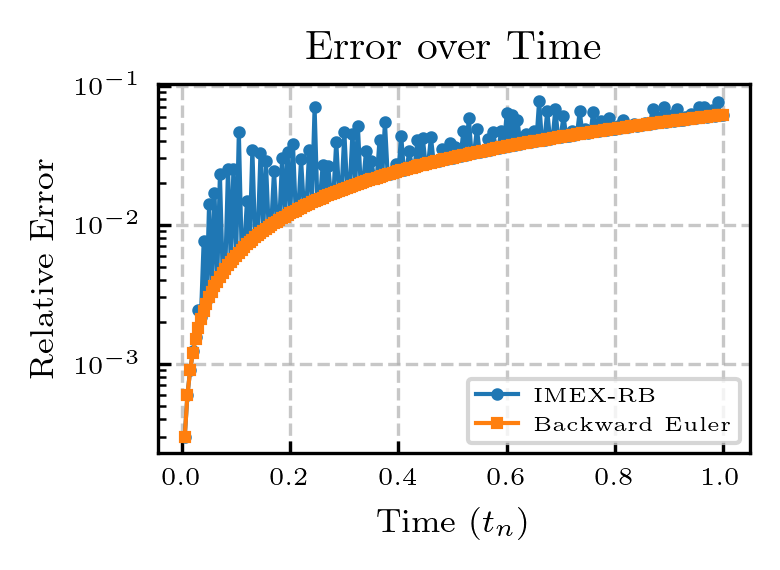

In [7]:
import matplotlib.pyplot as plt

# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem.domain, problem.exact_sol)
errBE = compute_errors(uBE, tvec, problem.domain, problem.exact_sol)
# errFE = compute_errors(uFE, tvec, problem.domain, problem.exact_sol)

# Plot the errors
plt.semilogy(tvec[1:], errIMEX, label="IMEX-RB", marker='o')
plt.semilogy(tvec[1:], errBE, label="Backward Euler", marker='s')
# plt.semilogy(tvec[1:], errFE, label="Forward Euler", marker='^')

# Add labels, legend, and title
plt.xlabel(r"Time $(t_n)$")
plt.ylabel("Relative Error")
plt.title("Error over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Plot the animation of the solution
Note that an animated plot in jupyter is not straightforward, and that is why there are some weird commands

In [8]:
# %matplotlib ipympl
# from IPython import display
# import time

# fig, ax = plt.subplots(1, 1)
# hdisplay = display.display("", display_id=True)

# # Set axis labels and limits
# ax.set_ylim(0, 1)
# ax.set_xlim(problem.domain[0], problem.domain[-1])
# ax.set_xlabel("Position (x)")
# ax.set_ylabel("Solution")

# # Initialize the line obj
# line_imex, = ax.plot([], [], "black", label="IMEX-RB")
# line_be, = ax.plot([], [], "red", linestyle="--", label="Backward Euler")
# ax.legend()

# for n, t in enumerate(tvec):
#     line_imex.set_data(problem.domain, uIMEX[:, n])  
#     line_be.set_data(problem.domain, uBE[:, n])      
#     hdisplay.update(fig)
#     # time.sleep(0.001)

# plt.close(fig)


Go back to `matplotlib inline`

In [9]:
%matplotlib inline

## Convergence test
We run a convergence test by computing the error at final time for different choices of $N_t$

In [10]:
# We now run a convergence test and plot the results
# Define the range of Nt values
Nt_values = [2**n for n in range(2, 10)]
errors_imex = []
errors_be = []
errors_fe = []

# Loop over Nt values
for Nt in Nt_values:
    # Time discretization
    tvec = np.linspace(t0, tf, Nt + 1)
    dt = tvec[1] - tvec[0]

    # Solve the problem with each scheme
    uIMEX, *_ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    uBE, *_ = backward_euler(problem, u0, tspan, Nt)
    uFE, *_ = forward_euler(problem, u0, tspan, Nt)

    # Compute errors at final time for each scheme
    err_imex = compute_errors(uIMEX, tvec, problem.domain, problem.exact_sol)
    err_be = compute_errors(uBE, tvec, problem.domain, problem.exact_sol)
    err_fe = compute_errors(uFE, tvec, problem.domain, problem.exact_sol)

    # Store the final error
    errors_imex.append(err_imex[-1])
    errors_be.append(err_be[-1])
    errors_fe.append(err_fe[-1])



/home/francesco/Desktop/EPFL_RESEARCH/Paper1/FD-PyIMEX-RB/utils/errors.py:29: RuntimeWarning: overflow encountered in square
  err_q_x[i - 1] = (dx * np.sum(np.abs(err)**q))**(1/q) / \
/home/francesco/anaconda3/envs/imexrb-FD/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/francesco/Desktop/EPFL_RESEARCH/Paper1/FD-PyIMEX-RB/src/euler.py:13: RuntimeWarning: invalid value encountered in add
  u[:, n+1] = u[:, n] + dt * problem.rhs(tvec[n], u[:, n])


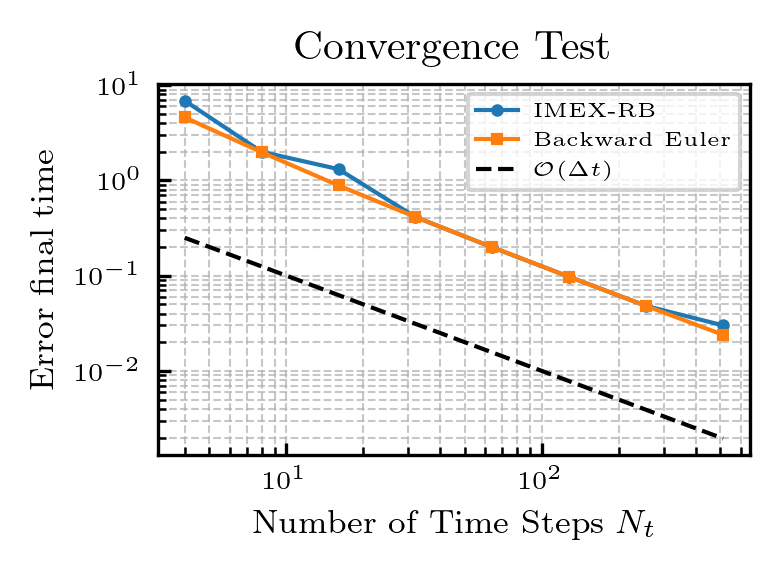

In [11]:
# Plot the convergence results
plt.loglog(Nt_values, errors_imex, label="IMEX-RB", marker='o', linestyle='-')
plt.loglog(Nt_values, errors_be, label="Backward Euler", marker='s', linestyle='-')
# plt.loglog(Nt_values, errors_fe, label="Forward Euler", marker='^', linestyle='-.')
plt.loglog(Nt_values, [1/Nt for Nt in Nt_values], label=r"$\mathcal{O}(\Delta t)$", color="k", linestyle='--')
plt.xlabel(r"Number of Time Steps $N_t$")
plt.ylabel("Error final time")
plt.title("Convergence Test")
plt.legend()
plt.grid(True, which="both", linewidth=0.5)
plt.show()